# Deep Fake Detection algorithm - Part 1 - Pre-Processing

In [2]:
import os 
import glob 
import json
import cv2
import numpy as np
import matplotlib.pyplot as plt
import copy
import h5py
import pickle
import pandas as pd

from math import log10, sqrt
from skimage.measure import compare_ssim
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.metrics import confusion_matrix


## supporting libraries

In [33]:
def create_video_dict():
    """ 
        creates a video dict, which maps:
        person -> videos -> cls[fake,original]
        
        there are two types of fakes, low and high
        quality.
    """
    
    videos = {}

    for f in glob.glob('data\*\*\*.avi'):
        _, video_type, person, video = f.split('\\')
        video = video.split('.')[0].split('-')[0] + '.avi'
        individual = videos.get(person,{})
        indiv_video = individual.get(video,{})
        indiv_video[video_type] = f
        individual[video] = indiv_video 
        videos[person] = individual

    prune_list = set()
    for person in videos:
        for video in videos[person]:
            video_types = list(videos[person][video].keys())
            if(len(video_types) == 1):
                prune_list.add(person)

    for person in prune_list:
        del videos[person]

    return videos

def write_json(videos):
    """
        write the videos structure to json
    """
    with open('meta_dict.json','w') as video_meta:
        video_meta.write(json.dumps(videos,sort_keys=True,indent=4))
    return 0

def get_videos():
    """ get json videos to save on compute """
    with open('meta_dict.json','r') as video_meta:
       videos = json.loads(video_meta.read())
    return videos

def get_all_video_frames(video):
    
    video_frames=[]
    
    cap = cv2.VideoCapture(video)
    
    video_err=0
    
    while(cap.isOpened()):
        ret,frame = cap.read()
        if ret == True:
            video_frames.append(frame)
        else:
            break
        
    cap.release()
    cv2.destroyAllWindows()
    return video_frames

def convert_video_to_numpy(video_frames):
    return np.vstack(video_frames)

def convert_to_jpg_and_store(image,store_name,person,video,video_type,frame):
    frame_path = 'data/{}/{}/{}/{}'.format(store_name,person,video,video_type)
    if(not os.path.exists(frame_path)):
        os.makedirs(frame_path)
    jpg_path = frame_path + '/{}_{}.jpg'.format(frame,video)
    cv2.imwrite(jpg_path,image)
    return 0

def write_video_to_folder(video_images,store_name,person,video,video_type):
    for i,frame in enumerate(video_images,start=0):
        convert_to_jpg_and_store(frame,store_name,person,video,video_type,i)
    return 0
    
def display_photo(frame):
    plt.figure()
    plt.imshow(frame[:,:,::-1])
    return 0

def detect_and_crop_face(frame):
    frame = copy.deepcopy(frame)
    
    face_cascade = cv2.CascadeClassifier('venv\Lib\site-packages\cv2\data\haarcascade_frontalface_alt.xml')
    
    grayscaled = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(grayscaled, 1.3, 5)
    
    for (x,y,w,h) in faces:
        cropped_photo = frame[y:y+h, x:x+w]
        
    if (len(faces) != 1):
        print("found: {} faces".format(len(faces)))
        cropped_photo = None
        
    cv2.waitKey(0)
    cv2.destroyAllWindows()
    return cropped_photo
    

## We pick: fadg0 person, sa1.avi video and look at high quality fake vs original

Let's focus on a single person: fadg0 and checkign out video clip sa1.avi.  We will only focus on the high quality deep fake and the original.  The below defines the video pathway.

In [4]:
current_client = 'fadg0'
current_video = 'sa1.avi'
original = 'originals'
fake = 'fakes_high_quality'

videos = get_videos()

current_videos = videos[current_client][current_video]
current_original = current_videos[original]
current_fake = current_videos[fake]
current_client_path = 'data/jpg/{}/{}/{}'.format(current_client,current_video,original)


## Write everything as jpeg to disk... 

Below we get all frames from the avi for both the deepfakes as well as the originals.  We also write all the frames as jpegs to disk.

In [5]:
all_fakes=get_all_video_frames(current_fake)
all_originals = get_all_video_frames(current_original)

write_video_to_folder(all_fakes,'jpg',current_client,current_video,fake)
write_video_to_folder(all_originals,'jpg',current_client,current_video,original)


0

## Contrast the original with the fake

we can subtract the images to gete a contrast.  We can see that the face itself pops up compared to the surrounding images.

In [6]:
contrast = all_fakes[0] - all_originals[0]

True

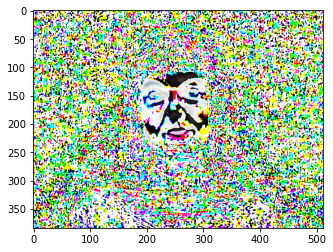

In [7]:
plt.figure()
plt.imshow(contrast[:,:,::-1])
cv2.imwrite('contrast.jpg',contrast)

## Analyzing color by histogram

Looking at the below histograms within the 20 to 100 RGB range for Green, Red and Blue.  We notice that the original is more smooth in terms of the histogram compared to the deep fake.  This hints that the gradient within the photo is finer in the originals compared to the deep fake.

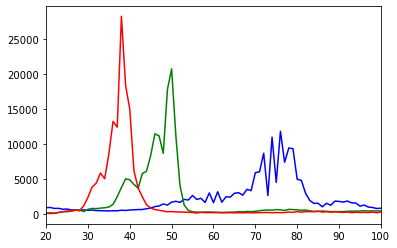

In [8]:
img = all_fakes[0]
color = ('b','g','r')
plt.figure()
for i,col in enumerate(color):
    histr = cv2.calcHist([img],[i],None,[256],[0,256])
    plt.plot(histr,color = col)
    plt.xlim([20,100])
plt.show()

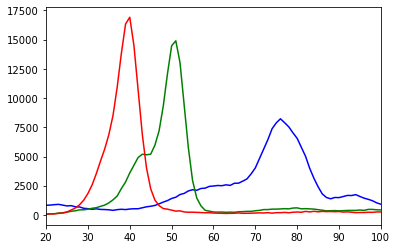

In [9]:
img = all_originals[0]
color = ('b','g','r')
plt.figure()
for i,col in enumerate(color):
    histr = cv2.calcHist([img],[i],None,[256],[0,256])
    plt.plot(histr,color = col)
    plt.xlim([20,100])
plt.show()

## Face detection and cropping

Here we go through an entire video, detect the face and than crop it.  We save this under cropped images.

In [10]:
fake_faces = []

for fake in all_fakes:
    face = detect_and_crop_face(fake)
    fake_faces.append(face)
    
original_faces = []

for original in all_originals:
    face = detect_and_crop_face(original)
    original_faces.append(face)
    
original = 'originals'
fake = 'fakes_high_quality'
      
write_video_to_folder(fake_faces,'cropped_faces',current_client,current_video,fake)
write_video_to_folder(original_faces,'cropped_faces',current_client,current_video,original)

0

# Deep Fake Detection algorithm - Part 2 - Feature Creation

In [40]:
def compare_faces(image1, image2):
    gray1 = cv2.cvtColor(image1, cv2.COLOR_BGR2GRAY)
    gray2 = cv2.cvtColor(image2, cv2.COLOR_BGR2GRAY)
    score, diff =  compare_ssim(gray1,gray2,full=True)
    return score,diff

def mse(image1, image2):
    err = np.sum((image1.astype("float") - image2.astype("float")) ** 2)
    err /= float(image1.shape[0] * image1.shape[1] * image1.shape[2])
    return err

def PSNR(image1, image2): 
    err = mse(image1,image2)
    if(err == 0):
        return 100
    max_pixel = 255.0
    psnr = 20 * log10(max_pixel / sqrt(err)) 
    return psnr 

def calculate_gray_hist(image1):
    gray = cv2.cvtColor(image1, cv2.COLOR_BGR2GRAY)
    hist,_ = np.histogram(gray.ravel(),256,[0,256])
    return hist

def calculate_feature_set(image1,label):
    feature_set = []
    
    frame = copy.deepcopy(image1)
    blur_frame = cv2.GaussianBlur(image1,(25,25),0)
    
    err = mse(frame,blur_frame)
    psnr = PSNR(frame,blur_frame)
    
    score, _ = compare_faces(frame,blur_frame)
    
    hist = calculate_gray_hist(frame)
    
    feature_set = np.append(hist, [err,psnr,score,label], axis=0)
    
    return feature_set
    

## Cropped image vs blurred image

0

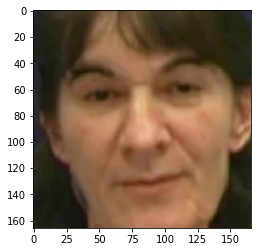

In [41]:
display_photo(detect_and_crop_face(all_fakes[0]))

0

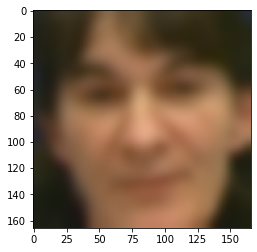

In [42]:
display_photo(cv2.GaussianBlur(detect_and_crop_face(all_fakes[0]),(25,25),0))

In [43]:
cropped_fake = detect_and_crop_face(all_fakes[0])
blurred_fake = cv2.GaussianBlur(detect_and_crop_face(all_fakes[0]),(25,25),0)

## SSIM, MSE, PSNR and histogram similarity

In [44]:
score, diff = compare_faces(cropped_fake,blurred_fake)

c:\users\silbe\desktop\deepfa~1\deepfa~2\venv\lib\site-packages\ipykernel_launcher.py:4: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_similarity. It will be removed from skimage.measure in version 0.18.
  after removing the cwd from sys.path.


SSIM Score: 0.8232490856250025


<Figure size 432x288 with 0 Axes>

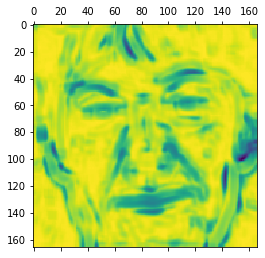

In [45]:
plt.figure()
plt.matshow(diff)
print("SSIM Score: {}".format(score))

In [46]:
print("MSE: {}".format(mse(cropped_fake, blurred_fake)))

MSE: 83.27012870760149


In [47]:
PSNR(cropped_fake, blurred_fake)

28.9259112493595

(256, 1)
(256, 1)
(256, 1)


array([[52, 50, 46, ..., 47, 47, 47],
       [51, 47, 40, ..., 46, 46, 46],
       [47, 43, 40, ..., 45, 46, 46],
       ...,
       [30, 30, 29, ..., 28, 30, 31],
       [30, 30, 30, ..., 26, 29, 30],
       [31, 31, 30, ..., 29, 29, 30]], dtype=uint8)

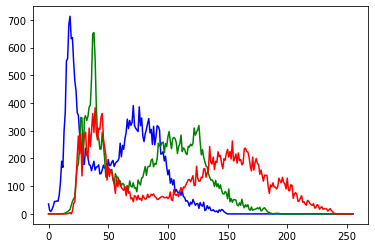

In [48]:
color_hist = {}
color = ('b','g','r')
plt.figure()
for i,col in enumerate(color):
    histr = cv2.calcHist([cropped_fake],[i],None,[256],[0,256])
    plt.plot(histr,color = col)
    print(histr.shape)

gray_cropped_fake = cv2.cvtColor(cropped_fake, cv2.COLOR_BGR2GRAY)
gray_cropped_fake

In [49]:
hist,bins = np.histogram(gray_cropped_fake.ravel(),256,[0,256])

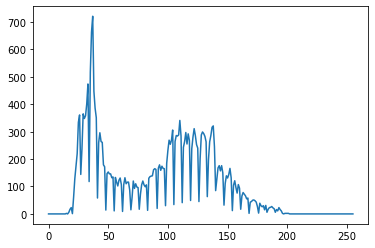

In [50]:
plt.figure()
plt.plot(hist)

## Calulating feature set

In [51]:
face_features = calculate_feature_set(cropped_fake,0)

c:\users\silbe\desktop\deepfa~1\deepfa~2\venv\lib\site-packages\ipykernel_launcher.py:4: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_similarity. It will be removed from skimage.measure in version 0.18.
  after removing the cwd from sys.path.


## Saving features to HDF5

In [52]:
faces_hf = h5py.File('faces.h5', 'w')
faces_hf.create_dataset('face1', data=face_features)

OSError: Unable to create file (unable to truncate a file which is already open)

# Deep Fake Detection algorithm - Part 3 -Training SVM

In [53]:
meta = get_videos()

## Crop all photos and put them on disk

In [24]:
# should probably make this multi-threaded or do some kind of numpy optimization... this is like terribly slow to do.
# that said, this seems to be the easiet solution compared to running out of memory on my private laptop.

video_list = get_videos()

all_videos = []

for person in video_list:
    for video in video_list[person]:
        for video_type in video_list[person][video]:
             all_videos += [ video_list[person][video][video_type] ]

good_frames = []
bad_frames = []

rewrite=1
                
for video in all_videos:
    video_frames = get_all_video_frames(video)
    for i, frame in enumerate(video_frames):
        cropped_face = detect_and_crop_face(frame)
        if(cropped_face is not None):
            new_jpg = os.path.basename(video).split('.')[0] + '_' + 'frame_{}'.format(i) + '.jpg'
            new_jpg_file = video.replace(os.path.basename(video),new_jpg)
            if (rewrite):
                cv2.imwrite(new_jpg_file,cropped_face)
            else:
                if(not os.path.exists(new_jpg_file)):
                    cv2.imwrite(new_jpg_file,cropped_face)
            good_frames.append(new_jpg_file)
        else:
            print("no face detected for: {}:{}".format(video,i))
            bad_frames.append([video, i])
    print("processed {} frames: {} frames with no faces: video {}".format(len(good_frames),len(bad_frames),video))

processed 119 frames: 0 frames with no faces: video data\fakes_high_quality\fadg0\sa1-video-fram1.avi
processed 238 frames: 0 frames with no faces: video data\fakes_low_quality\fadg0\sa1-video-fram1.avi
processed 357 frames: 0 frames with no faces: video data\originals\fadg0\sa1.avi
processed 460 frames: 0 frames with no faces: video data\fakes_high_quality\fadg0\sa2-video-fram1.avi
processed 563 frames: 0 frames with no faces: video data\fakes_low_quality\fadg0\sa2-video-fram1.avi
processed 666 frames: 0 frames with no faces: video data\originals\fadg0\sa2.avi
processed 738 frames: 0 frames with no faces: video data\fakes_high_quality\fadg0\si1279-video-fram1.avi
processed 810 frames: 0 frames with no faces: video data\fakes_low_quality\fadg0\si1279-video-fram1.avi
processed 882 frames: 0 frames with no faces: video data\originals\fadg0\si1279.avi
processed 999 frames: 0 frames with no faces: video data\fakes_high_quality\fadg0\si1909-video-fram1.avi
processed 1116 frames: 0 frames wi

processed 8358 frames: 8 frames with no faces: video data\originals\fcft0\sx188.avi
processed 8495 frames: 8 frames with no faces: video data\fakes_high_quality\fcft0\sx278-video-fdrd1.avi
processed 8632 frames: 8 frames with no faces: video data\fakes_low_quality\fcft0\sx278-video-fdrd1.avi
processed 8769 frames: 8 frames with no faces: video data\originals\fcft0\sx278.avi
processed 8891 frames: 8 frames with no faces: video data\fakes_high_quality\fcft0\sx368-video-fdrd1.avi
processed 9013 frames: 8 frames with no faces: video data\fakes_low_quality\fcft0\sx368-video-fdrd1.avi
processed 9135 frames: 8 frames with no faces: video data\originals\fcft0\sx368.avi
processed 9236 frames: 8 frames with no faces: video data\fakes_high_quality\fcft0\sx8-video-fdrd1.avi
processed 9337 frames: 8 frames with no faces: video data\fakes_low_quality\fcft0\sx8-video-fdrd1.avi
processed 9438 frames: 8 frames with no faces: video data\originals\fcft0\sx8.avi
processed 9509 frames: 8 frames with no fac

processed 15979 frames: 15 frames with no faces: video data\fakes_low_quality\fdrd1\sa2-video-fcft0.avi
processed 16082 frames: 15 frames with no faces: video data\originals\fdrd1\sa2.avi
processed 16169 frames: 15 frames with no faces: video data\fakes_high_quality\fdrd1\si1544-video-fcft0.avi
processed 16256 frames: 15 frames with no faces: video data\fakes_low_quality\fdrd1\si1544-video-fcft0.avi
processed 16343 frames: 15 frames with no faces: video data\originals\fdrd1\si1544.avi
processed 16486 frames: 15 frames with no faces: video data\fakes_high_quality\fdrd1\si1566-video-fcft0.avi
processed 16629 frames: 15 frames with no faces: video data\fakes_low_quality\fdrd1\si1566-video-fcft0.avi
processed 16772 frames: 15 frames with no faces: video data\originals\fdrd1\si1566.avi
found: 0 faces
no face detected for: data\fakes_high_quality\fdrd1\si2149-video-fcft0.avi:120
processed 16923 frames: 16 frames with no faces: video data\fakes_high_quality\fdrd1\si2149-video-fcft0.avi
proces

processed 23725 frames: 23 frames with no faces: video data\fakes_low_quality\felc0\sx216-video-fdac1.avi
processed 23804 frames: 23 frames with no faces: video data\originals\felc0\sx216.avi
processed 23884 frames: 23 frames with no faces: video data\fakes_high_quality\felc0\sx306-video-fdac1.avi
processed 23964 frames: 23 frames with no faces: video data\fakes_low_quality\felc0\sx306-video-fdac1.avi
processed 24044 frames: 23 frames with no faces: video data\originals\felc0\sx306.avi
processed 24157 frames: 23 frames with no faces: video data\fakes_high_quality\felc0\sx36-video-fdac1.avi
processed 24270 frames: 23 frames with no faces: video data\fakes_low_quality\felc0\sx36-video-fdac1.avi
processed 24382 frames: 23 frames with no faces: video data\originals\felc0\sx36.avi
processed 24523 frames: 23 frames with no faces: video data\fakes_high_quality\felc0\sx396-video-fdac1.avi
processed 24664 frames: 23 frames with no faces: video data\fakes_low_quality\felc0\sx396-video-fdac1.avi


processed 33367 frames: 27 frames with no faces: video data\originals\fjre0\si1116.avi
processed 33522 frames: 27 frames with no faces: video data\fakes_high_quality\fjre0\si1587-video-fcmh0.avi
processed 33677 frames: 27 frames with no faces: video data\fakes_low_quality\fjre0\si1587-video-fcmh0.avi
processed 33832 frames: 27 frames with no faces: video data\originals\fjre0\si1587.avi
processed 33921 frames: 27 frames with no faces: video data\fakes_high_quality\fjre0\si1746-video-fcmh0.avi
processed 34010 frames: 27 frames with no faces: video data\fakes_low_quality\fjre0\si1746-video-fcmh0.avi
processed 34099 frames: 27 frames with no faces: video data\originals\fjre0\si1746.avi
processed 34198 frames: 27 frames with no faces: video data\fakes_high_quality\fjre0\sx126-video-fcmh0.avi
processed 34297 frames: 27 frames with no faces: video data\fakes_low_quality\fjre0\sx126-video-fcmh0.avi
processed 34396 frames: 27 frames with no faces: video data\originals\fjre0\sx126.avi
processed 

processed 42380 frames: 28 frames with no faces: video data\fakes_high_quality\fram1\sa1-video-fadg0.avi
processed 42497 frames: 28 frames with no faces: video data\fakes_low_quality\fram1\sa1-video-fadg0.avi
processed 42614 frames: 28 frames with no faces: video data\originals\fram1\sa1.avi
processed 42741 frames: 28 frames with no faces: video data\fakes_high_quality\fram1\sa2-video-fadg0.avi
processed 42868 frames: 28 frames with no faces: video data\fakes_low_quality\fram1\sa2-video-fadg0.avi
processed 42995 frames: 28 frames with no faces: video data\originals\fram1\sa2.avi
processed 43110 frames: 28 frames with no faces: video data\fakes_high_quality\fram1\si1360-video-fadg0.avi
processed 43225 frames: 28 frames with no faces: video data\fakes_low_quality\fram1\si1360-video-fadg0.avi
processed 43339 frames: 28 frames with no faces: video data\originals\fram1\si1360.avi
processed 43548 frames: 28 frames with no faces: video data\fakes_high_quality\fram1\si522-video-fadg0.avi
proce

processed 50857 frames: 28 frames with no faces: video data\originals\mcem0\sx318.avi
processed 50949 frames: 28 frames with no faces: video data\fakes_high_quality\mcem0\sx408-video-mdld0.avi
processed 51041 frames: 28 frames with no faces: video data\fakes_low_quality\mcem0\sx408-video-mdld0.avi
processed 51133 frames: 28 frames with no faces: video data\originals\mcem0\sx408.avi
processed 51228 frames: 28 frames with no faces: video data\fakes_high_quality\mcem0\sx48-video-mdld0.avi
processed 51323 frames: 28 frames with no faces: video data\fakes_low_quality\mcem0\sx48-video-mdld0.avi
processed 51418 frames: 28 frames with no faces: video data\originals\mcem0\sx48.avi
processed 51567 frames: 28 frames with no faces: video data\fakes_high_quality\mdab0\sa1-video-mpdf0.avi
processed 51716 frames: 28 frames with no faces: video data\fakes_low_quality\mdab0\sa1-video-mpdf0.avi
processed 51865 frames: 28 frames with no faces: video data\originals\mdab0\sa1.avi
processed 51977 frames: 28

processed 59911 frames: 30 frames with no faces: video data\originals\mdld0\si913.avi
processed 59995 frames: 30 frames with no faces: video data\fakes_high_quality\mdld0\sx103-video-mcem0.avi
processed 60079 frames: 30 frames with no faces: video data\fakes_low_quality\mdld0\sx103-video-mcem0.avi
processed 60163 frames: 30 frames with no faces: video data\originals\mdld0\sx103.avi
processed 60248 frames: 30 frames with no faces: video data\fakes_high_quality\mdld0\sx13-video-mcem0.avi
processed 60333 frames: 30 frames with no faces: video data\fakes_low_quality\mdld0\sx13-video-mcem0.avi
processed 60418 frames: 30 frames with no faces: video data\originals\mdld0\sx13.avi
processed 60503 frames: 30 frames with no faces: video data\fakes_high_quality\mdld0\sx193-video-mcem0.avi
processed 60588 frames: 30 frames with no faces: video data\fakes_low_quality\mdld0\sx193-video-mcem0.avi
processed 60673 frames: 30 frames with no faces: video data\originals\mdld0\sx193.avi
processed 60777 fram

found: 0 faces
no face detected for: data\fakes_low_quality\mjar0\si728-video-mgwt0.avi:128
processed 66022 frames: 57 frames with no faces: video data\fakes_low_quality\mjar0\si728-video-mgwt0.avi
found: 0 faces
no face detected for: data\originals\mjar0\si728.avi:0
found: 0 faces
no face detected for: data\originals\mjar0\si728.avi:1
found: 0 faces
no face detected for: data\originals\mjar0\si728.avi:23
found: 0 faces
no face detected for: data\originals\mjar0\si728.avi:32
found: 0 faces
no face detected for: data\originals\mjar0\si728.avi:47
found: 0 faces
no face detected for: data\originals\mjar0\si728.avi:49
found: 0 faces
no face detected for: data\originals\mjar0\si728.avi:50
found: 0 faces
no face detected for: data\originals\mjar0\si728.avi:51
found: 0 faces
no face detected for: data\originals\mjar0\si728.avi:53
found: 0 faces
no face detected for: data\originals\mjar0\si728.avi:54
found: 0 faces
no face detected for: data\originals\mjar0\si728.avi:57
found: 0 faces
no face 

processed 66967 frames: 157 frames with no faces: video data\fakes_high_quality\mjar0\sx368-video-mgwt0.avi
processed 67100 frames: 157 frames with no faces: video data\fakes_low_quality\mjar0\sx368-video-mgwt0.avi
processed 67233 frames: 157 frames with no faces: video data\originals\mjar0\sx368.avi
processed 67346 frames: 157 frames with no faces: video data\fakes_high_quality\mjar0\sx8-video-mgwt0.avi
processed 67459 frames: 157 frames with no faces: video data\fakes_low_quality\mjar0\sx8-video-mgwt0.avi
processed 67571 frames: 157 frames with no faces: video data\originals\mjar0\sx8.avi
processed 67658 frames: 157 frames with no faces: video data\fakes_high_quality\mjar0\sx98-video-mgwt0.avi
processed 67745 frames: 157 frames with no faces: video data\fakes_low_quality\mjar0\sx98-video-mgwt0.avi
processed 67832 frames: 157 frames with no faces: video data\originals\mjar0\sx98.avi
processed 67926 frames: 157 frames with no faces: video data\fakes_high_quality\mjsw0\sa1-video-mmdb1.a

processed 74999 frames: 158 frames with no faces: video data\fakes_high_quality\mmdm2\si2028-video-mccs0.avi
processed 75066 frames: 158 frames with no faces: video data\fakes_low_quality\mmdm2\si2028-video-mccs0.avi
processed 75133 frames: 158 frames with no faces: video data\originals\mmdm2\si2028.avi
processed 75249 frames: 158 frames with no faces: video data\fakes_high_quality\mmdm2\sx102-video-mccs0.avi
processed 75365 frames: 158 frames with no faces: video data\fakes_low_quality\mmdm2\sx102-video-mccs0.avi
processed 75481 frames: 158 frames with no faces: video data\originals\mmdm2\sx102.avi
processed 75558 frames: 158 frames with no faces: video data\fakes_high_quality\mmdm2\sx12-video-mccs0.avi
processed 75635 frames: 158 frames with no faces: video data\fakes_low_quality\mmdm2\sx12-video-mccs0.avi
processed 75712 frames: 158 frames with no faces: video data\originals\mmdm2\sx12.avi
processed 75790 frames: 158 frames with no faces: video data\fakes_high_quality\mmdm2\sx192-vi

processed 82798 frames: 159 frames with no faces: video data\fakes_high_quality\mrcz0\sa2-video-mdbb0.avi
processed 82895 frames: 159 frames with no faces: video data\fakes_low_quality\mrcz0\sa2-video-mdbb0.avi
processed 82992 frames: 159 frames with no faces: video data\originals\mrcz0\sa2.avi
processed 83112 frames: 159 frames with no faces: video data\fakes_high_quality\mrcz0\si1541-video-mdbb0.avi
processed 83232 frames: 159 frames with no faces: video data\fakes_low_quality\mrcz0\si1541-video-mdbb0.avi
processed 83352 frames: 159 frames with no faces: video data\originals\mrcz0\si1541.avi
found: 0 faces
no face detected for: data\fakes_high_quality\mrcz0\si2171-video-mdbb0.avi:53
processed 83426 frames: 160 frames with no faces: video data\fakes_high_quality\mrcz0\si2171-video-mdbb0.avi
processed 83501 frames: 160 frames with no faces: video data\fakes_low_quality\mrcz0\si2171-video-mdbb0.avi
processed 83576 frames: 160 frames with no faces: video data\originals\mrcz0\si2171.avi
p

processed 91595 frames: 167 frames with no faces: video data\fakes_high_quality\mrjo0\sx14-video-mstk0.avi
processed 91712 frames: 167 frames with no faces: video data\fakes_low_quality\mrjo0\sx14-video-mstk0.avi
processed 91829 frames: 167 frames with no faces: video data\originals\mrjo0\sx14.avi
processed 91901 frames: 167 frames with no faces: video data\fakes_high_quality\mrjo0\sx194-video-mstk0.avi
processed 91973 frames: 167 frames with no faces: video data\fakes_low_quality\mrjo0\sx194-video-mstk0.avi
processed 92045 frames: 167 frames with no faces: video data\originals\mrjo0\sx194.avi
processed 92151 frames: 167 frames with no faces: video data\fakes_high_quality\mrjo0\sx284-video-mstk0.avi
processed 92257 frames: 167 frames with no faces: video data\fakes_low_quality\mrjo0\sx284-video-mstk0.avi
processed 92363 frames: 167 frames with no faces: video data\originals\mrjo0\sx284.avi
processed 92459 frames: 167 frames with no faces: video data\fakes_high_quality\mrjo0\sx374-video

processed 99921 frames: 169 frames with no faces: video data\originals\mwbt0\si1553.avi
processed 99979 frames: 169 frames with no faces: video data\fakes_high_quality\mwbt0\si2183-video-mpgl0.avi
processed 100037 frames: 169 frames with no faces: video data\fakes_low_quality\mwbt0\si2183-video-mpgl0.avi
processed 100095 frames: 169 frames with no faces: video data\originals\mwbt0\si2183.avi
processed 100200 frames: 169 frames with no faces: video data\fakes_high_quality\mwbt0\si923-video-mpgl0.avi
processed 100305 frames: 169 frames with no faces: video data\fakes_low_quality\mwbt0\si923-video-mpgl0.avi
processed 100410 frames: 169 frames with no faces: video data\originals\mwbt0\si923.avi
found: 0 faces
no face detected for: data\fakes_high_quality\mwbt0\sx113-video-mpgl0.avi:9
processed 100482 frames: 170 frames with no faces: video data\fakes_high_quality\mwbt0\sx113-video-mpgl0.avi
processed 100555 frames: 170 frames with no faces: video data\fakes_low_quality\mwbt0\sx113-video-mp

## Processed stats

In [62]:
print(len(good_frames))

101879


## Write bad and good frame references to file

In [60]:
with open('good_frames.txt','w') as good_frames_file:
    for f in good_frames:
        good_frames_file.write("{}\n".format(f))
        
print("wrote both good_frames.txt and bad_frames.txt")

wrote both good_frames.txt and bad_frames.txt


## Figure out HDF5 file clusterings...

In [56]:
good_frames = []

with open('good_frames.txt','r') as good_frames_file:
    for frame in good_frames_file:
        good_frames.append(frame.replace('\n',''))

parts = set()

video_dict = {}

for frame in good_frames:
    folder_base_name = os.path.dirname(frame)
    hdf5_base_name = os.path.basename(frame).split('_')[0] + '.h5'
    hdf5_key = os.path.join(folder_base_name, hdf5_base_name)
    
    current_frames = video_dict.get(hdf5_key,[])
    video_dict[hdf5_key] = current_frames
    current_frames.append(frame)
    


## Calculate per frame features and cluster them into hdf5 files

In [59]:
for key in video_dict:
    if ('fakes_low_quality' in key):
        continue
    with h5py.File(key,'w') as hdf5_file:
        if ("fakes" in key):
            label=0
        elif ("originals" in key):
            label=1
        video_frames = []
        for frame in video_dict[key]:
            cropped_image = cv2.imread(frame)
            features = calculate_feature_set(cropped_image,label)
            video_frames.append(features)
        video_features = convert_video_to_numpy(video_frames)
        hdf5_file.create_dataset(key, data=video_features)
    hdf5_file.close()
    print("finished: label={}, {}, data size: {}".format(label,key,video_features.shape))


c:\users\silbe\desktop\deepfa~1\deepfa~2\venv\lib\site-packages\ipykernel_launcher.py:4: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_similarity. It will be removed from skimage.measure in version 0.18.
  after removing the cwd from sys.path.


finished: label=0, data\fakes_high_quality\fadg0\sa1-video-fram1.h5, data size: (119, 260)
finished: label=1, data\originals\fadg0\sa1.h5, data size: (119, 260)
finished: label=0, data\fakes_high_quality\fadg0\sa2-video-fram1.h5, data size: (103, 260)
finished: label=1, data\originals\fadg0\sa2.h5, data size: (103, 260)
finished: label=0, data\fakes_high_quality\fadg0\si1279-video-fram1.h5, data size: (72, 260)
finished: label=1, data\originals\fadg0\si1279.h5, data size: (72, 260)
finished: label=0, data\fakes_high_quality\fadg0\si1909-video-fram1.h5, data size: (117, 260)
finished: label=1, data\originals\fadg0\si1909.h5, data size: (117, 260)
finished: label=0, data\fakes_high_quality\fadg0\si649-video-fram1.h5, data size: (216, 260)
finished: label=1, data\originals\fadg0\si649.h5, data size: (216, 260)
finished: label=0, data\fakes_high_quality\fadg0\sx109-video-fram1.h5, data size: (135, 260)
finished: label=1, data\originals\fadg0\sx109.h5, data size: (135, 260)
finished: label=

finished: label=1, data\originals\fdrd1\sa1.h5, data size: (136, 260)
finished: label=0, data\fakes_high_quality\fdrd1\sa2-video-fcft0.h5, data size: (103, 260)
finished: label=1, data\originals\fdrd1\sa2.h5, data size: (103, 260)
finished: label=0, data\fakes_high_quality\fdrd1\si1544-video-fcft0.h5, data size: (87, 260)
finished: label=1, data\originals\fdrd1\si1544.h5, data size: (87, 260)
finished: label=0, data\fakes_high_quality\fdrd1\si1566-video-fcft0.h5, data size: (143, 260)
finished: label=1, data\originals\fdrd1\si1566.h5, data size: (143, 260)
finished: label=0, data\fakes_high_quality\fdrd1\si2149-video-fcft0.h5, data size: (151, 260)
finished: label=1, data\originals\fdrd1\si2149.h5, data size: (152, 260)
finished: label=0, data\fakes_high_quality\fdrd1\sx104-video-fcft0.h5, data size: (76, 260)
finished: label=1, data\originals\fdrd1\sx104.h5, data size: (76, 260)
finished: label=0, data\fakes_high_quality\fdrd1\sx14-video-fcft0.h5, data size: (113, 260)
finished: label

finished: label=0, data\fakes_high_quality\fjre0\sa2-video-fcmh0.h5, data size: (87, 260)
finished: label=1, data\originals\fjre0\sa2.h5, data size: (87, 260)
finished: label=0, data\fakes_high_quality\fjre0\si1116-video-fcmh0.h5, data size: (85, 260)
finished: label=1, data\originals\fjre0\si1116.h5, data size: (85, 260)
finished: label=0, data\fakes_high_quality\fjre0\si1587-video-fcmh0.h5, data size: (155, 260)
finished: label=1, data\originals\fjre0\si1587.h5, data size: (155, 260)
finished: label=0, data\fakes_high_quality\fjre0\si1746-video-fcmh0.h5, data size: (89, 260)
finished: label=1, data\originals\fjre0\si1746.h5, data size: (89, 260)
finished: label=0, data\fakes_high_quality\fjre0\sx126-video-fcmh0.h5, data size: (99, 260)
finished: label=1, data\originals\fjre0\sx126.h5, data size: (99, 260)
finished: label=0, data\fakes_high_quality\fjre0\sx216-video-fcmh0.h5, data size: (82, 260)
finished: label=1, data\originals\fjre0\sx216.h5, data size: (82, 260)
finished: label=0,

finished: label=1, data\originals\mcem0\sa2.h5, data size: (78, 260)
finished: label=0, data\fakes_high_quality\mcem0\si1398-video-mdld0.h5, data size: (68, 260)
finished: label=1, data\originals\mcem0\si1398.h5, data size: (68, 260)
finished: label=0, data\fakes_high_quality\mcem0\si2028-video-mdld0.h5, data size: (126, 260)
finished: label=1, data\originals\mcem0\si2028.h5, data size: (126, 260)
finished: label=0, data\fakes_high_quality\mcem0\si768-video-mdld0.h5, data size: (112, 260)
finished: label=1, data\originals\mcem0\si768.h5, data size: (111, 260)
finished: label=0, data\fakes_high_quality\mcem0\sx138-video-mdld0.h5, data size: (104, 260)
finished: label=1, data\originals\mcem0\sx138.h5, data size: (104, 260)
finished: label=0, data\fakes_high_quality\mcem0\sx228-video-mdld0.h5, data size: (70, 260)
finished: label=1, data\originals\mcem0\sx228.h5, data size: (70, 260)
finished: label=0, data\fakes_high_quality\mcem0\sx318-video-mdld0.h5, data size: (75, 260)
finished: labe

finished: label=0, data\fakes_high_quality\mjar0\si1988-video-mgwt0.h5, data size: (75, 260)
finished: label=1, data\originals\mjar0\si1988.h5, data size: (75, 260)
finished: label=0, data\fakes_high_quality\mjar0\si2247-video-mgwt0.h5, data size: (76, 260)
finished: label=1, data\originals\mjar0\si2247.h5, data size: (76, 260)
finished: label=0, data\fakes_high_quality\mjar0\si728-video-mgwt0.h5, data size: (124, 260)
finished: label=1, data\originals\mjar0\si728.h5, data size: (80, 260)
finished: label=0, data\fakes_high_quality\mjar0\sx188-video-mgwt0.h5, data size: (96, 260)
finished: label=1, data\originals\mjar0\sx188.h5, data size: (78, 260)
finished: label=0, data\fakes_high_quality\mjar0\sx278-video-mgwt0.h5, data size: (151, 260)
finished: label=1, data\originals\mjar0\sx278.h5, data size: (151, 260)
finished: label=0, data\fakes_high_quality\mjar0\sx368-video-mgwt0.h5, data size: (133, 260)
finished: label=1, data\originals\mjar0\sx368.h5, data size: (133, 260)
finished: lab

finished: label=1, data\originals\mpgl0\si1099.h5, data size: (72, 260)
finished: label=0, data\fakes_high_quality\mpgl0\si1729-video-mwbt0.h5, data size: (104, 260)
finished: label=1, data\originals\mpgl0\si1729.h5, data size: (104, 260)
finished: label=0, data\fakes_high_quality\mpgl0\si469-video-mwbt0.h5, data size: (92, 260)
finished: label=1, data\originals\mpgl0\si469.h5, data size: (92, 260)
finished: label=0, data\fakes_high_quality\mpgl0\sx109-video-mwbt0.h5, data size: (110, 260)
finished: label=1, data\originals\mpgl0\sx109.h5, data size: (110, 260)
finished: label=0, data\fakes_high_quality\mpgl0\sx19-video-mwbt0.h5, data size: (88, 260)
finished: label=1, data\originals\mpgl0\sx19.h5, data size: (88, 260)
finished: label=0, data\fakes_high_quality\mpgl0\sx199-video-mwbt0.h5, data size: (94, 260)
finished: label=1, data\originals\mpgl0\sx199.h5, data size: (94, 260)
finished: label=0, data\fakes_high_quality\mpgl0\sx289-video-mwbt0.h5, data size: (98, 260)
finished: label=1

finished: label=0, data\fakes_high_quality\mstk0\si2222-video-mrjo0.h5, data size: (108, 260)
finished: label=1, data\originals\mstk0\si2222.h5, data size: (108, 260)
finished: label=0, data\fakes_high_quality\mstk0\si2284-video-mrjo0.h5, data size: (69, 260)
finished: label=1, data\originals\mstk0\si2284.h5, data size: (69, 260)
finished: label=0, data\fakes_high_quality\mstk0\sx124-video-mrjo0.h5, data size: (57, 260)
finished: label=1, data\originals\mstk0\sx124.h5, data size: (56, 260)
finished: label=0, data\fakes_high_quality\mstk0\sx214-video-mrjo0.h5, data size: (92, 260)
finished: label=1, data\originals\mstk0\sx214.h5, data size: (92, 260)
finished: label=0, data\fakes_high_quality\mstk0\sx304-video-mrjo0.h5, data size: (94, 260)
finished: label=1, data\originals\mstk0\sx304.h5, data size: (94, 260)
finished: label=0, data\fakes_high_quality\mstk0\sx34-video-mrjo0.h5, data size: (74, 260)
finished: label=1, data\originals\mstk0\sx34.h5, data size: (74, 260)
finished: label=0,

## Check out Training for next part of process...